In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Data-Glacier/Week 12/Data/newForecast.csv"
forecast = pd.read_csv(csv_path)
forecast.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7
3,3,SKU1,2017-02-26,26789,0.00,1,0,1,0.0,0,0,0,0,Sunday,1,8
4,4,SKU1,2017-03-05,41999,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,9


In [3]:
# Set date column to datetime object and remove unnamed column

forecast['date'] = pd.to_datetime(forecast['date'])
forecast.drop('Unnamed: 0', axis=1, inplace=True)
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7


In [4]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Product          1218 non-null   object        
 1   date             1218 non-null   datetime64[ns]
 2   Sales            1218 non-null   int64         
 3   Discount         1218 non-null   float64       
 4   In-Store Promo   1218 non-null   int64         
 5   Catalogue Promo  1218 non-null   int64         
 6   Store End Promo  1218 non-null   int64         
 7   Google_Mobility  1218 non-null   float64       
 8   Covid_Flag       1218 non-null   int64         
 9   V_DAY            1218 non-null   int64         
 10  EASTER           1218 non-null   int64         
 11  CHRISTMAS        1218 non-null   int64         
 12  DayOfWeek        1218 non-null   object        
 13  Quarter          1218 non-null   int64         
 14  WeekNum          1218 non-null   int64  

# Add Year, Month, and Day

In [5]:
forecast['Year'] = forecast['date'].dt.year
forecast['Month'] = forecast['date'].dt.month
forecast["Day"] = forecast['date'].dt.day
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,DayOfWeek,Quarter,WeekNum,Year,Month,Day
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,Sunday,1,5,2017,2,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,Sunday,1,6,2017,2,12
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,Sunday,1,7,2017,2,19


In [6]:
print(min(forecast["date"]))
print(max(forecast["date"]))

2017-02-05 00:00:00
2020-12-27 00:00:00


# Modeling

In [7]:
#Remove DayOfWeek column from dataframe

forecast = forecast.loc[:, forecast.columns != 'DayOfWeek']
forecast.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19


In [8]:
# Turn date column to int with a temporary df

df = forecast.copy()
df["date"] = df["date"].apply(lambda x: int(x.timestamp()))

In [9]:
#seperate by product

product1 = df[df["Product"] == "SKU1"]
product2 = df[df["Product"] == "SKU2"]
product3 = df[df["Product"] == "SKU3"]
product4 = df[df["Product"] == "SKU4"]
product5 = df[df["Product"] == "SKU5"]
product6 = df[df["Product"] == "SKU6"]

I will focus on product 1 for simplicity.

In [10]:
product1.head(3)

,Product,date,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
0,SKU1,1486252800,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
1,SKU1,1486857600,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2,SKU1,1487462400,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19


# Linear Regression
This is my base model.

In [11]:
#Evaluations

def evaluations(y_test, prediction):

    #mean squared error
    mse = mean_squared_error(y_test, prediction)

    #root mean squared error
    rmse = np.sqrt(mse)

    #mean absolut Error
    mae = mean_absolute_error(y_test, prediction)

    #Print
    print('Mean Absolute Error: %f' % mae)
    print("Mean Squared Error: %.3f" % mse)
    print('Root Mean Squared Error: %.3f' % rmse)

In [12]:
X = product1.loc[:, ~product1.columns.isin(['DayOfWeek', 'Sales', 'Product'])]
y = product1["Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

In [13]:
# fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations
evaluations(y_test, pred1)

Mean Absolute Error: 12602.135067
Mean Squared Error: 418595088.061
Root Mean Squared Error: 20459.596


# GridSearch CV

In [14]:
def gridsearch(model, parameters, X_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters,cv=5, n_jobs=None)
    result = grid.fit(X_train, y_train)

    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

In [15]:
# Train a linear regression model using grid search and cross-validation
model = LinearRegression()
param_grid = {'fit_intercept': [True, False],
              'positive': [True, False],
             'n_jobs': [1, 3, None]}
gridsearch(model, param_grid, X_train, y_train)

Best Score: 0.4879551565546906
Best Hyperparameters: {'fit_intercept': True, 'n_jobs': 1, 'positive': True}


In [16]:
#USE WITH BEST PARAMETERS

# fit the model
lr = LinearRegression(fit_intercept=True, n_jobs= 1, positive= True)
lr.fit(X_train, y_train)

# predict on the same period
pred1 = lr.predict(X_test)

#Evaluations
evaluations(y_test, pred1)

Mean Absolute Error: 12752.544756
Mean Squared Error: 438919569.518
Root Mean Squared Error: 20950.407


The original model performed the best.

# Random Forest

In [17]:
# fit the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations
evaluations(y_test, pred2)

Mean Absolute Error: 7520.470571
Mean Squared Error: 203332531.881
Root Mean Squared Error: 14259.472


# GridSearchCV

In [18]:
model = RandomForestRegressor()
param_grid = {'max_features' : ['sqrt',0.2],
              'n_estimators': [100, 200, 300, 500]
              #'min_samples_leaf': [1, 3,],

             #'n_jobs': [None, 3]
             }

gridsearch(model, param_grid, X_train, y_train)

Best Score: 0.6341555047530782
Best Hyperparameters: {'max_features': 0.2, 'n_estimators': 100}


In [19]:
# fit the model
rf = RandomForestRegressor(max_features = 'sqrt',n_estimators=200, random_state= 42)
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations
evaluations(y_test, pred2)

Mean Absolute Error: 7741.622571
Mean Squared Error: 161083953.937
Root Mean Squared Error: 12691.885


The original rf model performed better. The rf model performed bettwer than the lr model even though this model will need improvements.

# Feature Importance

In [20]:
#feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
Discount,0.331714
WeekNum,0.154157
Month,0.115959
date,0.103070
Day,0.078182
Catalogue Promo,0.042792
Year,0.039315
Quarter,0.036847
Store End Promo,0.032897
Covid_Flag,0.023497


<Figure size 1000x1500 with 0 Axes>

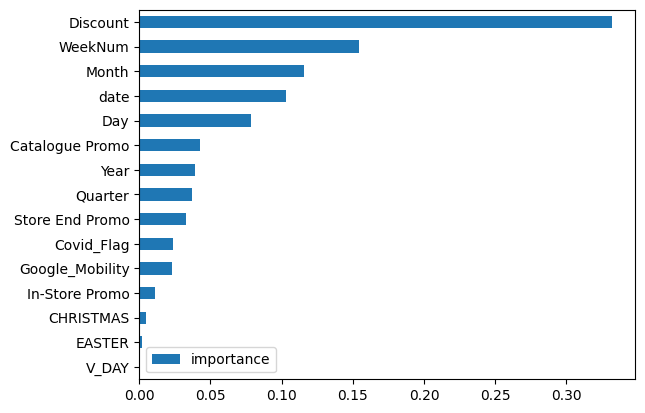

In [21]:
#plot importance
plt.figure(figsize=(10, 15))
feature_importances.plot(kind='barh').invert_yaxis()

# Testing

In [22]:
# Testing

# fit the model
rf = RandomForestRegressor(max_features = 0.2,n_estimators=100, min_samples_leaf=1,
                           n_jobs=None, random_state= 42)
rf.fit(X_train, y_train)

# predict on the same period
pred2 = rf.predict(X_test)

#Evaluations
evaluations(y_test, pred2)

Mean Absolute Error: 7616.845000
Mean Squared Error: 154867886.995
Root Mean Squared Error: 12444.593


# ARIMA

In [23]:
# Set index for date column with temp df2
df2 = forecast.copy()
df2.set_index('date', inplace=True)
df2.head(3)

,Product,Sales,Discount,In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Quarter,WeekNum,Year,Month,Day
date,,,,,,,,,,,,,,,,
2017-02-05,SKU1,27750,0.00,0,0,0,0.0,0,0,0,0,1,5,2017,2,5
2017-02-12,SKU1,29023,0.00,1,0,1,0.0,0,1,0,0,1,6,2017,2,12
2017-02-19,SKU1,45630,0.17,0,0,0,0.0,0,0,0,0,1,7,2017,2,19


In [24]:
#seperate by product

prod1 = df2[df2["Product"] == "SKU1"]
prod2 = df2[df2["Product"] == "SKU2"]
prod3 = df2[df2["Product"] == "SKU3"]
prod4 = df2[df2["Product"] == "SKU4"]
prod5 = df2[df2["Product"] == "SKU5"]
prod6 = df2[df2["Product"] == "SKU6"]

# Stat test if it is stationary or not using Augmented Dickey-Fuller Test

In [25]:
# ADF Test
# Function to print out results in customised manner
def adf_test(df):

    #df.index = df['date']

    # Check the data type
    #del df['date']
    del df["Product"]
    # View the dataset
    #df.head()

    timeseries = df["Sales"]

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [26]:
#product 1
adf_test(prod1)

Results of Dickey-Fuller Test:
Test Statistic                -8.709707e+00
p-value                        3.618957e-14
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [27]:
#product 2
adf_test(prod2)

Results of Dickey-Fuller Test:
Test Statistic                -1.510105e+01
p-value                        7.939761e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [28]:
#product 3
adf_test(prod3)

Results of Dickey-Fuller Test:
Test Statistic                -5.752370e+00
p-value                        5.925780e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


In [29]:
#product 4
adf_test(prod4)

Results of Dickey-Fuller Test:
Test Statistic                  -5.589760
p-value                          0.000001
#Lags Used                       3.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [30]:
#product 5
adf_test(prod5)

Results of Dickey-Fuller Test:
Test Statistic                  -4.407753
p-value                          0.000288
#Lags Used                       4.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


In [31]:
#product 6
adf_test(prod6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.259048
p-value                          0.000007
#Lags Used                       3.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


All of the products are stationary based on the Augmented Dickey-Fuller Test.

# ARIMA Model

In [32]:
model = pm.auto_arima(prod1['Sales'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4777.740, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4776.778, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4732.824, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4745.127, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5039.679, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4734.171, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4733.714, Time=1.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4734.340, Time=0.53 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4732.473, Time=0.17 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=4730.053, Time=0.43 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=4732.007, Time=1.98 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=4776.819, Time=0.54 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=4730.269, Time=0.94 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=4730.790, Time=1.05 sec
 ARIMA(0,0,1)(0,0,2

In [33]:
#split data

#X_train, X_test = train_test_split(product1.values, train_size=0.66, random_state=42)

In [34]:
#split data and have the last 12 rows for testing

X_train = prod1.iloc[:-12]
X_test = prod1.iloc[-12:]

In [35]:
#fit model
model.fit(X_train['Sales'])

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [36]:
"""pred = pd.DataFrame(model.predict(n_periods=12),index=X_test.index)
pred.columns = ["pred_sales"]
pred"""

'pred = pd.DataFrame(model.predict(n_periods=12),index=X_test.index)\npred.columns = ["pred_sales"]\npred'

In [37]:
#make predictions

forecast_pred=model.predict(n_periods=12, return_conf_int=True)
forecast_pred

(2020-10-11    50841.052250
 2020-10-18    46265.859791
 2020-10-25    45187.367635
 2020-11-01    45063.871285
 2020-11-08    48394.435097
 2020-11-15    44149.395045
 2020-11-22    42641.276282
 2020-11-29    46489.028253
 2020-12-06    52137.984051
 2020-12-13    47821.330528
 2020-12-20    47019.077747
 2020-12-27    48548.575230
 Freq: W-SUN, dtype: float64,
 array([[  -650.03282961, 102332.13732953],
        [ -9396.41914244, 101928.13872536],
        [-11147.67206251, 101522.40733285],
        [-11383.79161698, 101511.53418672],
        [ -8072.19152641, 104861.06172008],
        [-12320.42782591, 100619.21791613],
        [-13829.08539005,  99111.63795344],
        [ -9981.42424859, 102959.48075429],
        [ -4332.48376215, 108608.45186456],
        [ -8649.13986645, 104291.80092277],
        [ -9451.39308262, 103489.5485769 ],
        [ -7921.89567286, 105019.04613337]]))

In [38]:
forecast_pred[0].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 12 entries, 2020-10-11 to 2020-12-27
Freq: W-SUN
Series name: None
Non-Null Count  Dtype  
--------------  -----  
12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [39]:
forecastdf = forecast_pred[0].to_frame(name='pred_sales')

In [40]:
forecastdf

,pred_sales
2020-10-11,50841.052250
2020-10-18,46265.859791
2020-10-25,45187.367635
2020-11-01,45063.871285
2020-11-08,48394.435097
2020-11-15,44149.395045
2020-11-22,42641.276282
2020-11-29,46489.028253
2020-12-06,52137.984051
2020-12-13,47821.330528


In [41]:
len(X_test)

12

In [44]:
X_test['pred_sales'] = forecastdf

<ipython-input-44-216975d23c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred_sales'] = forecastdf


In [45]:
#Evaluations
evaluations(X_test["Sales"], X_test['pred_sales'])

Mean Absolute Error: 26532.321470
Mean Squared Error: 1150890319.614
Root Mean Squared Error: 33924.774


# SARIMA Model

I also wanted to try a univariate model to test how it will perform.

In [56]:
train_data = prod1[["Sales"]].iloc[:-12]
test_data = prod1[["Sales"]].iloc[-12:]

In [57]:
model = SARIMAX(
train_data['Sales'], order =(1, 1, 1), seasonal_order=(1, 1, 1, 12))

result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [58]:
forecast = result.get_forecast(steps=12)
predicted_demand = forecast.predicted_mean

evaluations(test_data, predicted_demand)

Mean Absolute Error: 26299.801293
Mean Squared Error: 1092712025.502
Root Mean Squared Error: 33056.195


# Random Forest Model for each product

In [59]:
def rf(df):
  X = df.loc[:, ~df.columns.isin(['DayOfWeek', 'Sales', 'Product'])]
  y = df["Sales"]

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)

  # predict on the same period
  pred2 = rf.predict(X_test)

  #Evaluations
  evaluations(y_test, pred2)

In [65]:
#product 1
rf(product1)

Mean Absolute Error: 7401.053000
Mean Squared Error: 211634115.540
Root Mean Squared Error: 14547.650


In [60]:
#product 2
rf(product2)

Mean Absolute Error: 1111.725857
Mean Squared Error: 6196412.108
Root Mean Squared Error: 2489.259


In [61]:
#product 3
rf(product3)

Mean Absolute Error: 13239.009571
Mean Squared Error: 615781157.663
Root Mean Squared Error: 24814.938


In [62]:
#product 4
rf(product4)

Mean Absolute Error: 4464.547143
Mean Squared Error: 67990522.775
Root Mean Squared Error: 8245.637


In [63]:
#product 5
rf(product5)

Mean Absolute Error: 1518.985714
Mean Squared Error: 8614557.851
Root Mean Squared Error: 2935.057


In [64]:
#product 6
rf(product6)

Mean Absolute Error: 7650.997794
Mean Squared Error: 210165569.195
Root Mean Squared Error: 14497.088



# Key Findings
---


1. Discount and WeekNum are the two most important features.

2. The Random Forest model performed the best with a Mean Absolute error of 7,616.85 for product1.

3. Product 2 and 5 performed the best with the random forest model. Poduct 2 had the least amount of total sales, so I wonder if that is a contributing factor.

4. Product 3 had the worst performance with random forest. Product 3 also had the highest mount of total sales. I wonder if that is a contributing factor.

# Recomendations
---


I would suggest to get more data for each product to help build a better model. Instead of getting salesweekly maybe collect daily sales in order to get more data.